<a href="https://colab.research.google.com/github/sahil-bhatia-iitbhu/deepseek-from-scratch/blob/main/04_tokenizer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Input the raw data and tokenize: The Verdict Story

In [1]:
import os
import requests

if not os.path.exists("the-verdict.txt"):
  url = (
      "https://raw.githubusercontent.com/sahil-bhatia-iitbhu/deepseek-from-scratch/main/04_input_the-verdict.txt"
  )
  file_path = "the-verdict.txt"

  response = requests.get(url, timeout=30)
  response.raise_for_status()
  with open(file_path, "wb") as f:
      f.write(response.content)
  # After writing, get raw_text from response.content
  raw_text = response.content.decode('utf-8')
else:
  # If the file already exists, read it
  with open("the-verdict.txt", "r", encoding='utf-8') as f:
      raw_text = f.read()

print(f"Total number of characters in the text file:\n{len(raw_text)}")
print(" ")
print(f"Sample Raw Text:\n{raw_text[:99]}")

Total number of characters in the text file:
20479
 
Sample Raw Text:
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [2]:
# let's first understand the tool for Step 1: Tokenizing the Text
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)

print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


In [3]:
# If we want to split on not only whitespaces but on different other types of period and punctuation

text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


In [4]:
# Now let's tokenize our raw_text

preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(f"Token Sample:\n{preprocessed[:30]}")
print(" ")
print(f"Total number of tokens:\n{len(preprocessed)}")

Token Sample:
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']
 
Total number of tokens:
4690


### Generate Token IDs and Create *class* for both encoders and decoders

In [5]:
unique_words = set(preprocessed)
print(f"Total number of unique words:\n{len(unique_words)}\n")

all_words = sorted(unique_words)
print(f"Sample sorted unique words:\n{all_words[:29]}\n")

vocab_size = len(all_words)
print(f"Vocabulary Size:\n{vocab_size}")

Total number of unique words:
1130

Sample sorted unique words:
['!', '"', "'", '(', ')', ',', '--', '.', ':', ';', '?', 'A', 'Ah', 'Among', 'And', 'Are', 'Arrt', 'As', 'At', 'Be', 'Begin', 'Burlington', 'But', 'By', 'Carlo', 'Chicago', 'Claude', 'Come', 'Croft']

Vocabulary Size:
1130


In [6]:
# now, let's assign unique integer to each token, means generating token IDs

vocab = {token:integer for integer,token in enumerate(all_words)}

In [7]:
print("Sample Token ID - Token Space\n")
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 20:
        break

Sample Token ID - Token Space

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)


In [8]:
## We would create a tokenizer class for both encoding and decoding
## encoding converts the input to token IDs present in the vocabulary
## decoding converts the token IDs back to text

class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)

        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [9]:
# setup the class with vocabulary
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know,"
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 56, 2, 850, 988, 602, 533, 746, 5, 1126, 596, 5, 1, 67, 7, 38, 851, 1108, 754, 793, 7]


In [10]:
# hope we get the same text back from the IDs
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

### Adding Special Context Token

Some tokenizers use special tokens to help the LLM with additional context

Some of these special tokens are:

- [BOS] (beginning of sequence) marks the beginning of text
- [EOS] (end of sequence) marks where the text ends (this is usually used to concatenate multiple unrelated texts, e.g., two different Wikipedia articles or two different books, and so on)
- [PAD] (padding) if we train LLMs with a batch size greater than 1 (we may include multiple texts with different lengths; with the padding token we pad the shorter texts to the longest length so that all texts have an equal length)
- [UNK] to represent words that are not included in the vocabulary

Note that GPT/Deepseek does not need any of these tokens mentioned above but only uses an <|endoftext|> token to reduce complexity

The <|endoftext|> is analogous to the [EOS] token mentioned above

GPT/Deepseek also uses the <|endoftext|> for padding (since we typically use a mask when training on batched inputs, we would not attend padded tokens anyways, so it does not matter what these tokens are)

GPT/Deepseek does not use an <UNK> token for out-of-vocabulary words; instead, GPT-2 uses a byte-pair encoding (BPE) tokenizer, which breaks down words into subword units which we will discuss in a later section

In [14]:
# Lets first hit a text with unknown word in out v1 tokenizer

tokenizer = SimpleTokenizerV1(vocab)

text = "Hello, do you like tea. Is this-- a test?"

try:
  tokenizer.encode(text)
except:
  print("No Such Token Present")

# we would get an error as "Hello" is not present in the vocabulary

No Such Token Present


In [12]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [16]:
print(f"Updated length of vocabulary: {len(vocab.items())}")

Updated length of vocabulary: 1132


In [17]:
# The appended tokens are added at the end of the vocabulary

for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


In [18]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [19]:
# Now, let's test the V2 of tokenizer

tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [20]:
tokenizer.encode(text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

In [21]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

### Byte-Pair Encoding

BPE tokenizers break down unknown words into subwords and individual characters

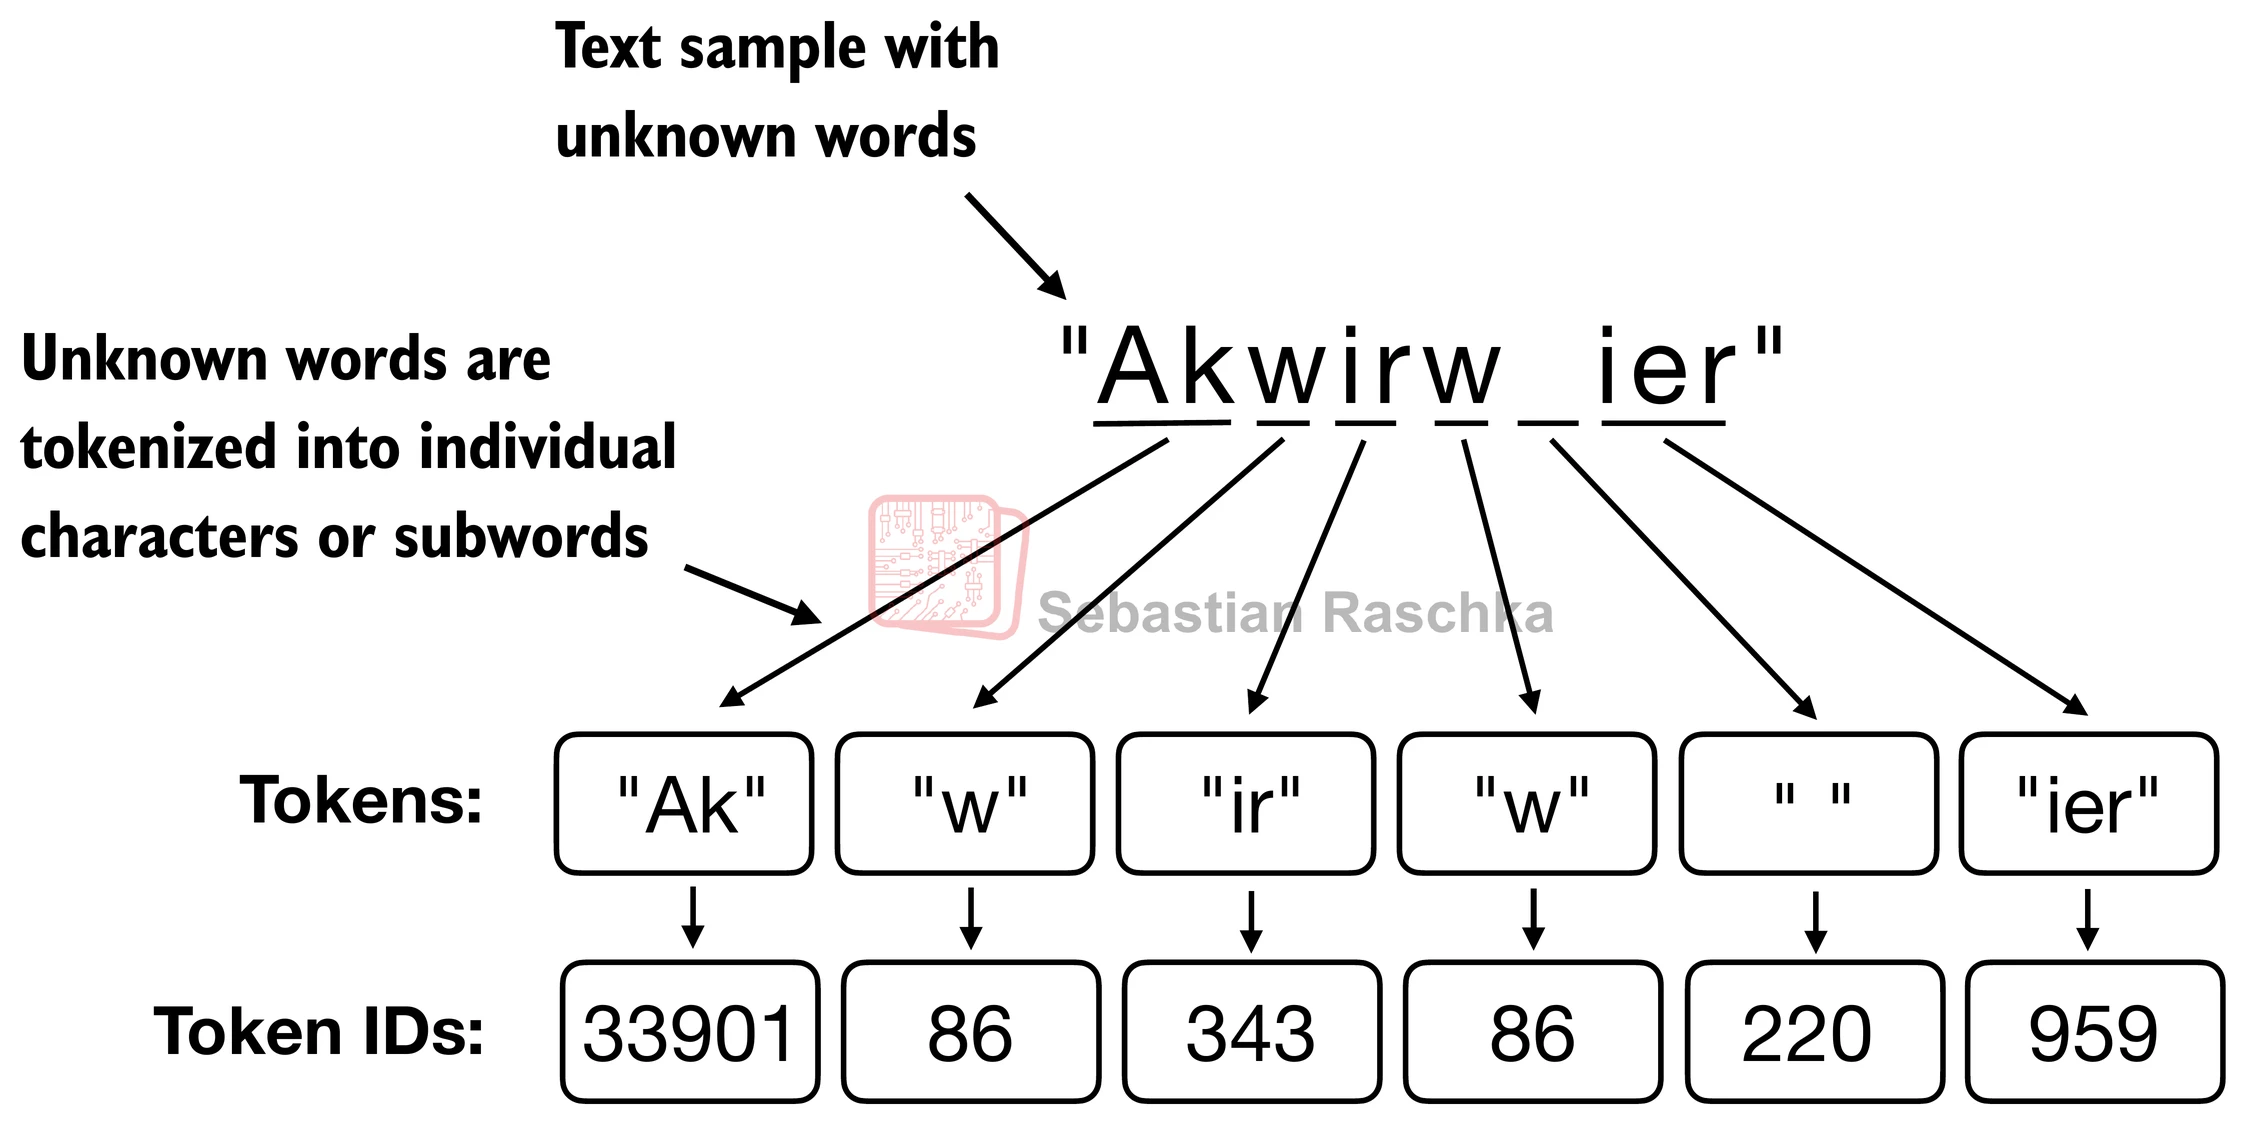

In [28]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.12.0


In [25]:
tokenizer = tiktoken.get_encoding("gpt2")

In [26]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces"
     "of someunknownPlace."
)

integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})

print(integers)

[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 1659, 617, 34680, 27271, 13]


In [27]:
strings = tokenizer.decode(integers)

print(strings)

Hello, do you like tea? <|endoftext|> In the sunlit terracesof someunknownPlace.


### Input - Target Pairs

We train LLMs to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict:

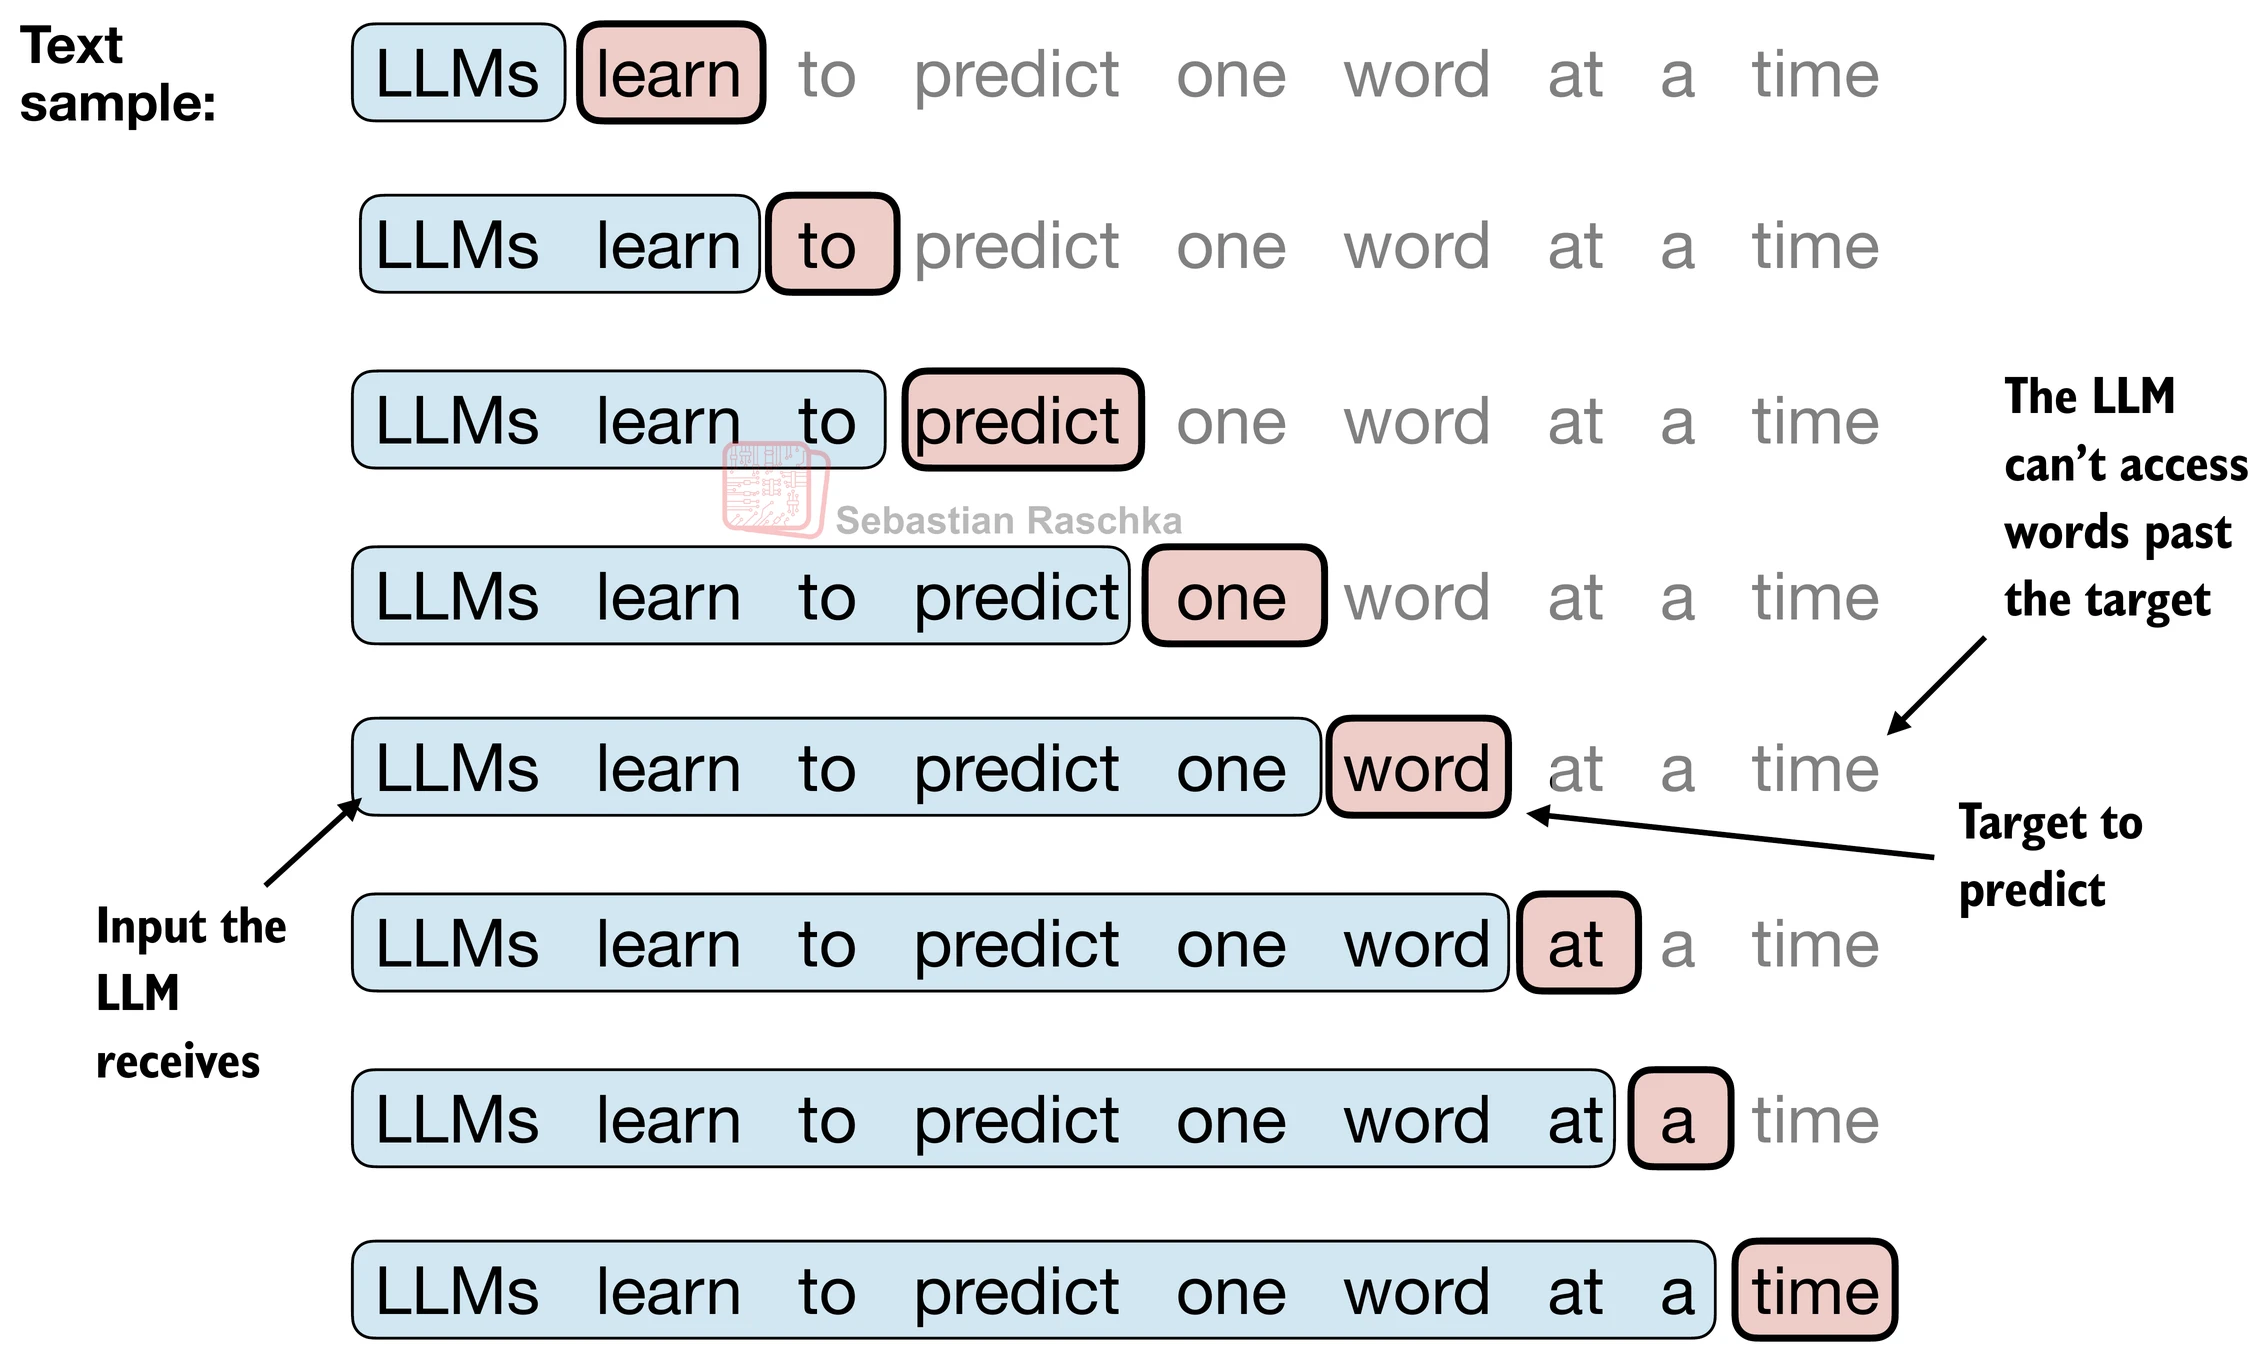

In [30]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

enc_text = tokenizer.encode(raw_text)
print(f"Token length in our input data: ",len(enc_text))

Token length in our input data:  5145


- For each text chunk, we want the inputs and targets
- Since we want the model to predict the next word, the targets are the inputs shifted by one position to the right
- sequence length indicates the length of tokens model is trained to look at a time

In [33]:
context_size = 4

x = enc_text[:context_size]
y = enc_text[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

x: [40, 367, 2885, 1464]
y:      [367, 2885, 1464, 1807]


In [35]:
# One by one, the prediction would look like as follows:

for i in range(1, context_size+1):
    context = enc_text[:i]
    desired = enc_text[i]

    print(context, "---->", desired)

[40] ----> 367
[40, 367] ----> 2885
[40, 367, 2885] ----> 1464
[40, 367, 2885, 1464] ----> 1807


In [36]:
for i in range(1, context_size+1):
    context = enc_text[:i]
    desired = enc_text[i]

    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

I ---->  H
I H ----> AD
I HAD ---->  always
I HAD always ---->  thought


**Setting up the dataloader in pytorch**

In [37]:
import torch
print("PyTorch version:", torch.__version__)

PyTorch version: 2.9.0+cu126


In [38]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [39]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [40]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [41]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [42]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


In [43]:
# We can also create batched outputs
# Note that we increase the stride here so that we don't have overlaps between the batches, since more overlap could lead to increased overfitting

dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


### Token Embeddings